# Image Classification using Convolutional Neural Networks (CNN) - X-ray Images
**Author**: Group 6 - Angela Nyaga, 
                      Sophy Owuor and 
                      Rowlandson Kariuki

# Overview

In this project, we will utilize a pre-trained CNN model to predict the classification of X-ray images.

# Business Problem

The medical dataset comprises X-ray images of pediatric patients, indicating the presence or absence of pneumonia. Our goal is to develop a model capable of determining whether a given patient has pneumonia based on a chest X-ray image. Utilizing image analysis, classification techniques, and convolutional neural networks (CNNs), our objective is to accurately identify X-rays with a pneumonia diagnosis. Considering the limited availability of radiologists at any given time, the aspiration is that a model trained on CNNs can correctly interpret and analyze X-rays, even for those lacking specialized human expertise.

In [2]:
# importing necessary libraries
# Standard Libraries
import os

# Data Manipulation Libraries
import numpy as np
from PIL import Image

# Data Splitting and Preprocessing
import splitfolders
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# Setup and Preprocessing

**Examining our directory structure and establishing the necessary file paths for upcoming tasks**

The original datset (CellData) upon download is divided into two folders: "train" and "test". Both the train and test folders contain two folders: one for "normal" xray images and the other for xray images showing patients with pneumonia. 

In [3]:
# Define the base directory path for chest X-ray images
images_home = 'CellData/chest_xray/'

# Define directory paths for training, testing, and validation sets
train_files = images_home + "train/"
test_files = images_home + "test/"


In [4]:
# Print the list of filenames in the training directory
print(os.listdir(train_files))

['NORMAL', 'PNEUMONIA']


In [5]:
# Define directory paths for normal and pneumonia training images
train_norm = train_files+"NORMAL/"
train_sick = train_files+"PNEUMONIA/"

# Define directory paths for normal and pneumonia training images
test_norm = test_files+"NORMAL/"
test_sick = test_files+"PNEUMONIA/"

In [6]:
# Print the number of images in the normal and pneumonia training directories
print("Number of normal training images is : ", len(os.listdir(train_norm)))
print("Number of sick training images is : ", len(os.listdir(train_sick)))
print("Number of normal testing images is : ", len(os.listdir(test_norm)))
print("Number of sick testing images is : ", len(os.listdir(test_sick)))

Number of normal training images is :  1349
Number of sick training images is :  3883
Number of normal testing images is :  234
Number of sick testing images is :  390


The current directory structure lacks a set of images that we can use to validate during the modelling process. A validation set helps in tuning hyperparameters and preventing overfitting. It is different from the test set, which is reserved for final model analysis. Because the training set of images contains more images, we will use a subset of it to create a validation set. We will use split folders library because of the simplicity of use. 


In [7]:
# make sure to run pip install split-folders if you don't have the library
# taking images from the train folder
input_folder = train_files
output_folder = "train_files/val_files"

# Specify the split ratios
split_ratios = (0.7, 0.3)

# Perform the split
splitfolders.ratio(input_folder, output_folder, seed=42, ratio=split_ratios, group_prefix=None)

Copying files: 5232 files [00:21, 243.55 files/s]


The path to our directory has changed with the split. We therefore need to redefine the path to our train dataset and our newly created validation dataset.

In [8]:
# specifying path to newly created train and validation set 
train_files = "train_files/val_files/train/"
train_norm = train_files +"NORMAL/"
train_sick = train_files +"PNEUMONIA/"

val_files = "train_files/val_files/val/"
val_norm = val_files +"NORMAL/"
val_sick = val_files +"PNEUMONIA/"

# Inspecting how many images are left in the training set and how many are in the val set
print("No of normal train images after split is:", len(os.listdir(train_norm)))
print("No of sick train images after split is:",len(os.listdir(train_sick)))

print("No of normal val images is:", len(os.listdir(val_norm)))
print("No of sick val images is:", len(os.listdir(val_sick)))

No of normal train images after split is: 944
No of sick train images after split is: 2718
No of normal val images is: 405
No of sick val images is: 1165


The split was successful. However, with 944 normal images and 2718 "sick"images in the training dataset, there is a class imbalance that may introduce bias to our model. This will be dealt with by ********$$$$$$$

**Investigating the characteristics of our images**

Text(0.5, 1.0, 'Pneumonia')

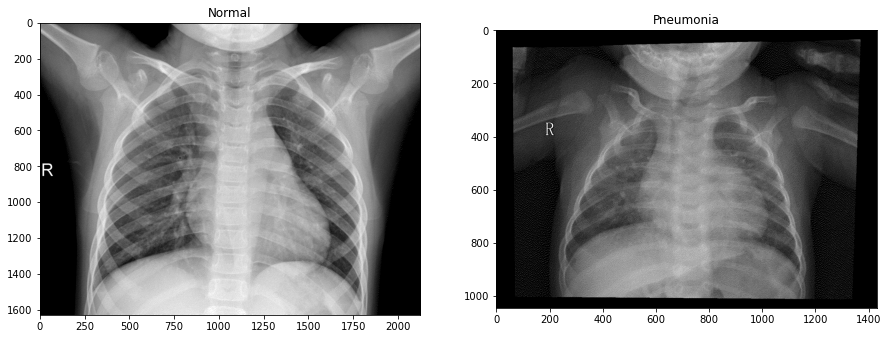

In [9]:

# Select the 41st image from the normal and pneumonia training directories
norm_pic_file = os.listdir(train_norm)[40]
sick_pic_file = os.listdir(train_sick)[40]

# Build full file paths for the selected images
norm_pic_full_filename = train_norm + norm_pic_file
sick_pic_full_filename = train_sick + sick_pic_file

# Load and convert the selected images to binary (black and white)
pic_norm = Image.open(norm_pic_full_filename).convert('1')
pic_sick = Image.open(sick_pic_full_filename).convert('1')

# Create a figure for side-by-side visualization of the normal and pneumonia images
f = plt.figure(figsize=(15,15))
a_norm = f.add_subplot(1,2,1)
img_plot = plt.imshow(pic_norm)
a_norm.set_title("Normal")

a_sick = f.add_subplot(1,2,2)
img_plot = plt.imshow(pic_sick)
a_sick.set_title("Pneumonia")

There exists a disparity in the sizes of the images, indicating a potential imbalance. 

In [10]:
# confirming that the images are of different sizes 
print(pic_norm.size)
print(pic_sick.size)

(2124, 1630)
(1431, 1044)


We need to standardize the images by resizing them. CNN will only accept inputs that have fixed sizes. Furthermore, resizing ensures that when modelling, our input has consistent features and patterns, therefore reducing the chances of overfitting. We will create a new directory for the resized images as opposed to overwriting the original images. Though the latter is more efficient, it will lead to loss of original data, which may be needed for future comparison. 


In [11]:
# Target size based on the images above
target_size = (1000,1000)  

# we want to resize both the normal and pneumonia images in the train files
# variable "train norm" contains directory path to where all the normal train images are found
# Get a list of all normal train image files in the directory
normal_train_list = os.listdir(train_norm)

# Create a new directory to store resized images
resized_images_directory = "train_files/val_files/train_resized/NORMAL/"
os.makedirs(resized_images_directory, exist_ok=True)

# Resize each normal image and save it to the new directory
for image_file in normal_train_list:
    image_path = os.path.join(train_norm, image_file)
    resized_image = Image.open(image_path).resize(target_size)
    
    # Save the resized image to the new directory
    resized_image_path = os.path.join(resized_images_directory, image_file)
    resized_image.save(resized_image_path)

In [12]:
# variable "train sick" contains directory path to where all the sick train images are found
# Get a list of all "sick" train image files in the directory
sick_train_list = os.listdir(train_sick)

# Create a new directory to store resized images
resized_images_directory = "train_files/val_files/train_resized/PNEUMONIA/"
os.makedirs(resized_images_directory, exist_ok=True)

# Resize each normal image and save it to the new directory
for image_file in sick_train_list:
    image_path = os.path.join(train_sick, image_file)
    resized_image = Image.open(image_path).resize(target_size)
    
    # Save the resized image to the new directory
    resized_image_path = os.path.join(resized_images_directory, image_file)
    resized_image.save(resized_image_path)

In [13]:
# specifying path to the new set of resized train images
train_files_resized = "train_files/val_files/train_resized/"
train_norm_resized = train_files_resized +"NORMAL/"
train_sick_resized = train_files_resized +"PNEUMONIA/"

Text(0.5, 1.0, 'Pneumonia')

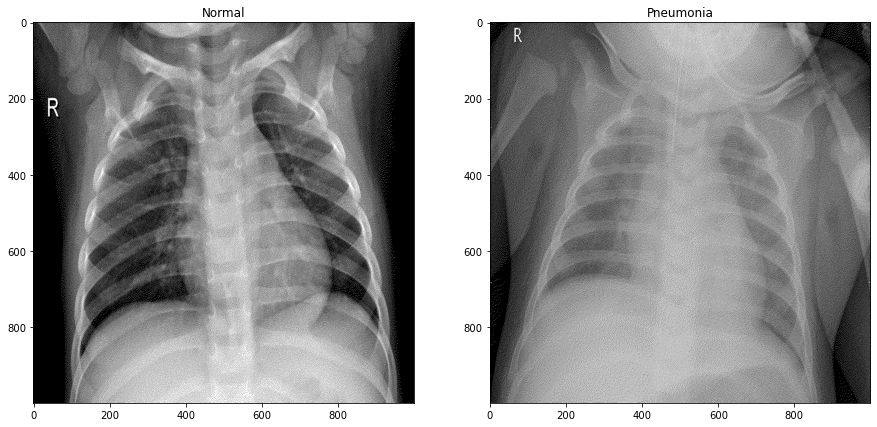

In [46]:
# Using the same code above to visually inspect whether our images have been resized
# Select random images from the normal and pneumonia training directories
norm_pic_file = os.listdir(train_norm_resized)[42]
sick_pic_file = os.listdir(train_sick_resized)[55]

# Build full file paths for the selected images
norm_pic_full_filename = train_norm_resized + norm_pic_file
sick_pic_full_filename = train_sick_resized + sick_pic_file

# Load and convert the selected images to binary (black and white)
pic_norm = Image.open(norm_pic_full_filename).convert('1')
pic_sick = Image.open(sick_pic_full_filename).convert('1')

# Create a figure for side-by-side visualization of the normal and pneumonia images
f = plt.figure(figsize=(15,15))
a_norm = f.add_subplot(1,2,1)
img_plot = plt.imshow(pic_norm)
a_norm.set_title("Normal")

a_sick = f.add_subplot(1,2,2)
img_plot = plt.imshow(pic_sick)
a_sick.set_title("Pneumonia")

In [32]:
# confirming resizing
print(pic_norm.size)
print(pic_sick.size)

(1000, 1000)
(1000, 1000)


**Examing the pixel values of our images**

In [48]:
# reopen our images without converting them to binary format
pic_norm = Image.open(norm_pic_full_filename)
pic_sick = Image.open(sick_pic_full_filename)

# Convertimage to a NumPy array to access pixel values
pixel_values_norm = list(pic_norm.getdata())
pixel_values_sick = list(pic_sick.getdata())

# Display the pixel values
print("Pixel values before rescaling:", pixel_values_norm[500:550])
print("Pixel values before rescaling:", pixel_values_sick[1000:1050])

Pixel values before rescaling: [168, 171, 169, 166, 171, 170, 169, 167, 167, 168, 169, 169, 171, 174, 177, 178, 176, 174, 171, 170, 169, 172, 177, 182, 184, 184, 182, 181, 182, 188, 195, 200, 201, 199, 195, 193, 174, 175, 173, 168, 161, 153, 148, 145, 148, 147, 147, 144, 134, 121]
Pixel values before rescaling: [44, 31, 18, 15, 17, 18, 18, 19, 19, 19, 20, 22, 25, 25, 23, 21, 16, 16, 15, 14, 11, 9, 7, 5, 3, 4, 5, 7, 7, 8, 7, 7, 6, 9, 11, 11, 9, 6, 6, 6, 8, 13, 18, 19, 18, 19, 21, 23, 20, 23]


We need to normalize our pixel values. Normalizing them will lead to better performance of our neural network and will also increase the computational efficiency. 

In [52]:
# rescale training images
# training images were already resized
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_files_resized,
                                                                         batch_size=100,shuffle=False)

# rescale validation images
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_files, target_size=(1000,1000),
                                                                       batch_size = 100,shuffle=False) 

# rescale test images
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_files, target_size=(1000,1000),
                                                                       batch_size = 100,shuffle=False) 

Found 3662 images belonging to 2 classes.
Found 1570 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [53]:
train_generator

In [ ]:
model = Sequential()


In [ ]:
# two convolution layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# one flatten layer
model.add(Flatten())

# one dense layer
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))